<a href="https://colab.research.google.com/github/dvircohen0/Machine-Learning-Algorithms-From-Scratch/blob/main/RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import tensorflow_datasets as tfds
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tqdm.notebook as tq
import time
import random

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
!wget https://raw.githubusercontent.com/Hulkido/RCNN/master/Airplanes_Annotations.zip
!unzip /content/Airplanes_Annotations.zip
!wget https://raw.githubusercontent.com/Hulkido/RCNN/master/Images.zip
!unzip Images.zip

In [5]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [6]:
def get_rectangle(csv_annot):
    df = pd.read_csv(csv_annot)
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        box={"x1":x1,"x2":x2,"y1":y1,"y2":y2}
    return box

In [7]:
def rectang_from_image(image,x,y,w,h):
    timage = image[y:y+h,x:x+w]
    resized = cv2.resize(timage,
                     (224,224),
                     interpolation = cv2.INTER_AREA)
    return resized

In [8]:
max_proposal = 2000
max_samples = 30
IOU_treshold_plane = 0.7
IOU_treshold_background = 0.3

dataset_path = "/content/Images"
annot="/content/Airplanes_Annotations"

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

box_values = []
train_images=[]
train_labels=[]
images=os.listdir(dataset_path)

In [20]:
for file in tq.tqdm(images[:100], desc="creating dataset"):
    try:
        image=cv2.imread(os.path.join(dataset_path,file))
        csv_path = os.path.join(annot,file.split(".")[0]+".csv")
        box_values.append(get_rectangle(csv_path))
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        counter=flag=falsecounter=fflag=bflag = 0
        for e, result in  enumerate(ssresults):
            if e< max_proposal and flag==0:
                for a_box in box_values:
                    x,y,w,h = result
                    iou = get_iou(a_box,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < max_samples:
                        if iou > IOU_treshold_plane:
                            train_images.append(rectang_from_image(image,x,y,w,h))
                            train_labels.append(1)
                            counter +=1
                    else:
                        fflag = 1
                    if falsecounter <30:
                        if iou < IOU_treshold_background:
                            train_images.append(rectang_from_image(image,x,y,w,h))
                            train_labels.append(0)
                            falsecounter += 1
                    else:
                        bflag = 1
                if fflag == 1 and bflag==1:
                    flag=1
    except Exception as e:
        print(e)
        continue

In [42]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

vggmodel = VGG16(weights='imagenet', include_top=True)

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(1, activation="sigmoid")(X)
model_final = Model(vggmodel.input,predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.binary_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [43]:
X_train, X_test , y_train, y_test = train_test_split(X_new,y_new,test_size=0.10)

In [44]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5",
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto', period=1)

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0,
                      patience=100,
                      verbose=1,
                      mode='auto')

hist = model_final.fit_generator(generator= traindata,
                                 steps_per_epoch= 10,
                                 epochs= 10, 
                                 validation_data= testdata,
                                 validation_steps=2,
                                 callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 6s 545ms/step - loss: 0.8623 - accuracy: 0.7456 - val_loss: 0.3581 - val_accuracy: 0.8594

Epoch 00001: val_loss improved from inf to 0.35810, saving model to ieeercnn_vgg16_1.h5
Epoch 2/10
10/10 [==============================] - 5s 504ms/step - loss: 0.4035 - accuracy: 0.8310 - val_loss: 0.3192 - val_accuracy: 0.8906

Epoch 00002: val_loss improved from 0.35810 to 0.31920, saving model to ieeercnn_vgg16_1.h5
Epoch 3/10
10/10 [==============================] - 5s 497ms/step - loss: 0.4733 - accuracy: 0.7661 - val_loss: 0.2724 - val_accuracy: 0.8750

Epoch 00003: val_loss improved from 0.31920 to 0.27244, saving model to ieeercnn_vgg16_1.h5
Epoch 4/10
10/10 [==============================] - 5s 492ms/step - loss: 0.2931 - accuracy: 0.8861 - val_loss: 0.2350 - val_accuracy: 0.9062

Epoch 00004: val_loss improved from 0.27244 to 0.23501, saving model to ieeercnn_vgg16_1.h5
Epoch 5/10
10/10 [==============================] - 5s 491ms/ste

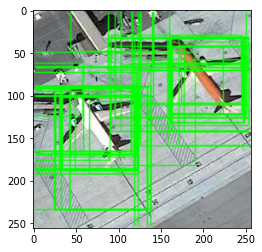

In [57]:
img=random.choice(images)
img = cv2.imread(os.path.join(dataset_path,img))
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        if out[0][0] > 0.7:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)
